In [ ]:
# inhibitory synapse .. with E=20 .. means it should be GABA synapse 
# but they are using equation for AMPA synapse 


In [27]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
from brainpy._src.integrators import JointEq
from brainpy._src.context import share
import numpy as np 

bp.math.set_dt(0.04)

In [28]:
class A2(bp.neurons.HH):
    def __init__(self, size, ENa=120., EK=-12., EL=10.6, C=1.0, gNa=120.,
               gK=36, gL=0.3, V_th=0., method='exp_auto'):
        super().__init__(size=size, method=method)
        self.size = size

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        self.input = bm.Variable(bm.ones(size) * 9)
        self.t_last_spike = bm.Variable(bm.ones(size) * -1e7)

    def dm(self, m, t, V):
        alpha =  0.1*(25-V) / (bm.exp(2.5 - 0.1*V)-1) #0.1 * (25-V) / (bm.exp(-0.1 * (V - 25)) - 1)
        beta = 4.0*bm.exp(-V/18.0) # 4 * bm.exp(-V / 18)
        dmdt = alpha * (1 - m) - beta * m
        return dmdt

    def dn(self, n, t, V):
        alpha = 0.01*(10.0-V)/ (bm.exp(1.0-0.1*V )-1) #0.01 * (10-V) / (bm.exp(0.1 * (10-V)) - 1)
        beta = 0.125*bm.exp(-V/80.0) #0.125 * bm.exp(-V / 80)
        dndt = alpha * (1 - n) - beta * n
        return  dndt

    def dh(self, h, t, V):
        alpha = 0.07*bm.exp(-V/20.0) #0.07 * bm.exp(-V / 20)
        beta = 1/(1+bm.exp(3.0-0.1*V)) #1 / (bm.exp(0.1 * (-V + 30)) + 1)
        dhdt = alpha * (1 - h) - beta * h
        return dhdt

    def dV(self, V, t, m, h, n, I):
        INa = self.gNa * m ** 3 * h * (V - self.ENa)
        IK = self.gK * n ** 4 * (V - self.EK)
        IL = self.gL * (V - self.EL)
        dVdt = (- INa - IK - IL + I) / self.C
        return dVdt

    @property
    def derivative(self):
        return JointEq(self.dV, self.dm, self.dh, self.dn)  # , self.dh, self.dn, self.ds, self.dc, self.dq)

#     def update(self, tdi):
#         # t = share.load('t')
#         # dt = share.load('dt')
#         # x = 1.2 if x is None else x
#         # print('x=', x )

#         V, m, h, n = self.integral(self.V.value, self.m.value, self.h.value, self.n.value, tdi.t, self.input, tdi.dt)
#         # V += self.sum_delta_inputs()
#         self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
#         # self.t_last_spike.value = bm.where(self.spike, tdi.t, self.t_last_spike)
#         self.V.value = V
#         self.h.value = h
#         self.n.value = n
#         # self.input[:] = x
#         return self.spike.value


num = 100
# dyn neurons
neu =  A2(num) #A1(num) #bp.neurons.HH(num)#bp.dyn.HH(10) #HH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num) #bp.dyn.WangBuzsakiHH(num) #bp.neurons.WangBuzsakiModel(num) #HH(num)
# neu = bp.neurons.HH(100)
neu.V[:] =-70. + bm.random.normal(size=num)*20

In [29]:
# print(neu.V.value,neu.m.value, neu.h.value, neu.n.value)
neu.V[:] = neu.V[:]#. + bm.random.normal(size=num) 
# neu.V[:] = -70. + bm.random.normal(size=num) 
alpha_m = 0.1 * (25-neu.V) / (bm.exprel(-0.1 * (neu.V - 25)) - 1)
#1. / bm.exprel(-(neu.V + 40) / 10) #0.1 * (25-neu.V[:]) / (bm.exp(-0.1 * (neu.V[:] - 25)) - 1)
beta_m = 4 * bm.exp(-neu.V[:] / 18)
#4.0 * bm.exp(-(neu.V + 65) / 18) #4 * bm.exp(-neu.V[:] / 18)
neu.m[:] = 0 # alpha_m/ (alpha_m + beta_m)
alpha_h = 0.07 * bm.exp(-neu.V / 20)
#0.07 * bm.exp(-(neu.V + 65) / 20.) # 0.07 * bm.exp(-neu.V / 20)
beta_h = 1 / (bm.exp(0.1 * (-neu.V + 30)) + 1) #
#1 / (1 + bm.exp(-(neu.V + 35) / 10)) #1 / (bm.exp(0.1 * (-neu.V + 30)) + 1)
neu.h[:] = 0 # alpha_h/ (alpha_h + beta_h)
alpha_n = 0.01 * (10-neu.V) / (bm.exprel(0.1 * (10-neu.V)) - 1) #0.1 / bm.exprel(-(V + 55) / 10) #
beta_n = 0.125 * bm.exp(-neu.V / 80) #0.125 * bm.exp(-(V + 65) / 80) #
neu.n[:] = 0 # alpha_n/ (alpha_n + beta_n)
print(round(bm.mean(neu.m),3), round(bm.mean(neu.h),3),round(bm.mean(neu.n),3))

0.0 0.0 0.0


In [4]:
class BaseAMPASyn(bp.SynConn):
    def __init__(self, pre, post, conn, delay=0, g_max=0.001, E=20, alpha=0.98,
               beta=0.18, 
               T=1, T_duration=1, method='exp_auto'):
        super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attribute: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.delay = delay
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration

        # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
        self.delay_step = int(delay/bm.get_dt())
        self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

        # store the arrival time of the pre-synaptic spikes
        self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

        # integral function
        self.integral = bp.odeint(self.derivative, method=method)

    def derivative(self, g, t, TT):
        dg = self.alpha * TT * (1 - g) - self.beta * g
       
        # dg = -g + ((1-g)*5)/(1+bm.exp(-(self.pre.V+3)/8))  # according to paper 
        return dg
    
   

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.SynConn is deprecated. Use brainpy.dyn.SynConn instead.
  _deprecate(message)


In [5]:
class AMPAAll2All(BaseAMPASyn):
    def __init__(self, *args, **kwargs):
        super(AMPAAll2All, self).__init__(*args, **kwargs)

        # synapse gating variable
        # -------
        # The synapse variable has the shape of the post-synaptic group
        self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        delayed_spike = self.pre_spike(self.delay_step)
        self.pre_spike.update(self.pre.spike)
        self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
        TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
        TT = TT.reshape((-1, 1))  # NOTE: here is the difference
        self.g.value = self.integral(self.g, _t, TT, dt=_dt)
        g_post = self.g.sum(axis=0) # NOTE: here is also different
        # self.post.input += bm.dot(self.g_max,g_post) * (self.E - self.post.V)
        self.post.input += bm.dot(self.g_max,g_post) * (self.E - self.post.V)
        
        # self.post.input += self.g_max * g_post * (self.E - self.post.V) 
        # self.post.input += self.g_max @g_post * (self.E - self.post.V)
        #bm.dot(self.g_max,g_post) * (self.E - self.post.V)/99

In [6]:
# for more details of how to run a simulation please see the tutorials in "Dynamics Simulation"

def show_syn_model(model):
    pre =  neu #bp.neurons.HH(100) #LIF(100, V_rest=-60., V_reset=-60., V_th=-40.)
    post = neu #bp.neurons.HH(100) #LIF(100, V_rest=-60., V_reset=-60., V_th=-40.)
    syn = model(pre, pre, conn=bp.conn.All2All(include_self=False))
    shape = (100,100)
    syn.g_max = bp.init.Normal(mean=0.1, scale=0.02)(shape) /99
    net = bp.Network(pre=pre, post=post, syn=syn)

    runner = bp.DSRunner(net,
                       monitors=['pre.V', 'post.V', 'syn.g','pre.spike'],
                       inputs=['pre.input', bm.random.uniform(9,10,100)])
    runner.run(300.)

    fig, gs = bp.visualize.get_figure(1, 3, 3, 4)
    fig.add_subplot(gs[0, 0])
    bp.visualize.line_plot(runner.mon.ts, runner.mon['syn.g'], legend='syn.g')
    fig.add_subplot(gs[0, 1])
    bp.visualize.line_plot(runner.mon.ts, runner.mon['pre.V'], legend='pre.V')
    # bp.visualize.line_plot(runner.mon.ts, runner.mon['post.V'], legend='post.V', show=True)
    fig.add_subplot(gs[0, 2])
    bp.visualize.raster_plot(runner.mon.ts, runner.mon['pre.spike'], show=True)

In [7]:
 #if i run last cell it will take up its updated value ☹️

  0%|          | 0/7500 [00:00<?, ?it/s]

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


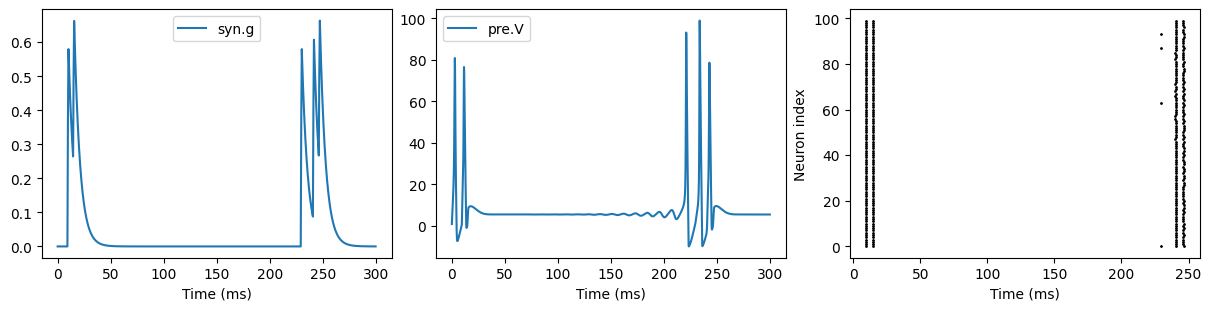

In [8]:
show_syn_model(AMPAAll2All)

In [9]:
class AMPA(bp.Projection):
    def __init__(self, pre, post, delay, prob, weight, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre,
          delay=delay,
          syn=bp.dyn.AMPA.desc(pre.num, alpha=0.98, beta=0.18, T=0.5, T_dur=0.5),
          comm=bp.dnn.AllToAll(pre.num, post.num, weight) ,
            #bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), weight),
          out=bp.dyn.COBA(E=E),
          post=post,
        )

weights= (100, 100)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)


  0%|          | 0/1000 [00:00<?, ?it/s]

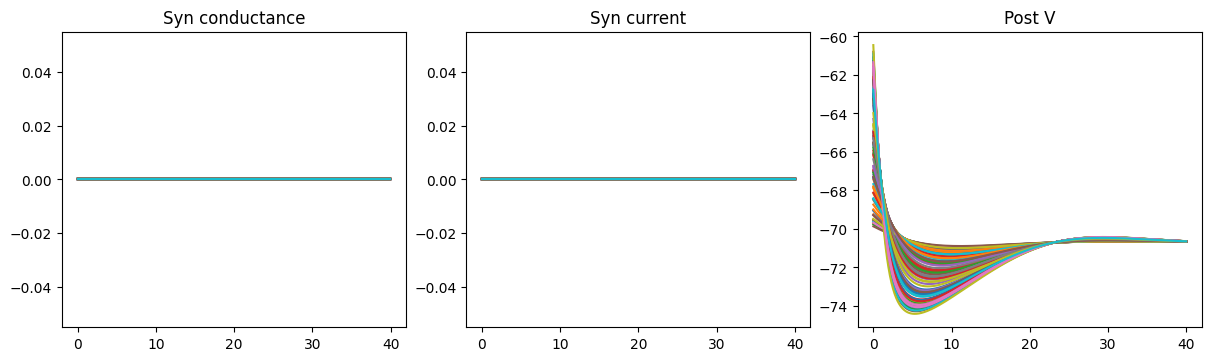

In [10]:
        
class SimpleNet(bp.DynSysGroup):
    def __init__(self, E=0.):
        super().__init__()

        self.pre = bp.neurons.HH(100)#bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
        self.post = bp.neurons.HH(100) #neu #bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                                  # V_initializer=bp.init.Constant(-60.))
        self.syn = AMPA(self.pre, self.post, delay=0, prob=1., weight=bp.init.Normal(0.1/100,0.02/100), E=E)##bp.init.Normal(0.1,0.02), E=E)
        print('weights=', self.syn.proj.comm.weight.shape)

    def update(self):
        self.pre()
        self.syn()
        self.post()

        # monitor the following variables
        conductance = self.syn.proj.refs['syn'].g
        current = self.post.sum_current_inputs(self.post.V)
        return conductance, current, self.pre.V,self.pre.spike

indices = np.arange(1000)  # 100 ms, dt= 0.1 ms
# with bm.environment(mode=bm.nonbatching_mode):
conductances, currents, potentials,spks = bm.for_loop(SimpleNet(E=20.).step_run, indices, progress_bar=True)
ts = indices * bm.get_dt()


fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
fig.add_subplot(gs[0, 0])
plt.plot(ts, conductances)
plt.title('Syn conductance')
fig.add_subplot(gs[0, 1])
plt.plot(ts, currents)
# bp.visualize.raster_plot(ts, spks, show=True)
plt.title('Syn current')
fig.add_subplot(gs[0, 2])
plt.plot(ts, potentials)
plt.title('Post V')
plt.show()

# AMPA_fixedprob

In [11]:
class AMPAAll2All(BaseAMPASyn):
    def __init__(self, *args, **kwargs):
        super(AMPAAll2All, self).__init__(*args, **kwargs)

        self.conn_mat = self.conn.require('conn_mat').astype(float)

        # synapse gating variable
        # -------
        # The synapse variable has the shape of the post-synaptic group
        self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
        # self.g = bm.Variable(bm.zeros( self.post.num))

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        delayed_spike = self.pre_spike(self.delay_step)
        self.pre_spike.update(self.pre.spike)
        self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
        TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
                      #*1/(1+bm.exp(-(self.pre.V-20)/2)))
                # TT = 1/(1+bm.exp(-(self.pre.V+3)/8))
                # TT = TT.reshape((-1, 1))  # NOTE: here is the difference
        TT = TT.reshape((-1, 1))*self.g_max  # NOTE: here is the difference
        # TT2 =  self.g_max @ TT.reshape((-1, 1))
        # # TT = bm.dot(TT,self.g_max )
        self.g.value = self.integral(self.g, _t, TT, dt=_dt)
         # g_post =  bm.dot(self.g_max, self.g )
        g_post = self.g.sum(axis=0) # NOTE: here is also different
        
        # get the post-synaptic current
        # self.post.input += #self.g_max,g_post * (self.E - self.post.V)/99 #20
                # self.post.input += bm.dot(self.g_max,g_post) * (self.E - self.post.V)/99 #20
        self.post.input += g_post * (self.E - self.post.V)/99 #20
                # self.post.input += (self.g_max * g_post) * (self.E - self.post.V)/100

                # self.post.input += self.g_max * g_post * (self.E - self.post.V)
       
        

# AMPA_All2all connection 

In [12]:
 class AMPAAll2All(BaseAMPASyn):
    def __init__(self, *args, **kwargs):
        super(AMPAAll2All, self).__init__(*args, **kwargs)

        self.conn_mat = self.conn.require('conn_mat').astype(float)

        # synapse gating variable
        # -------
        # The synapse variable has the shape of the post-synaptic group
        self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))
        # self.g = bm.Variable(bm.zeros( self.post.num))

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        delayed_spike = self.pre_spike(self.delay_step)
        self.pre_spike.update(self.pre.spike)
        self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
        TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
              #*1/(1+bm.exp(-(self.pre.V-20)/2)))
        # TT = 1/(1+bm.exp(-(self.pre.V+3)/8))
        TT = TT.reshape((-1, 1))  # NOTE: here is the difference
        self.g.value = self.integral(self.g, _t, TT, dt=_dt)
        g_post = self.g.sum(axis=0) # NOTE: here is also different
        self.post.input += bm.dot(self.g_max,g_post) * (self.E - self.post.V)/99 #20
        print('output =', self.post.input)
        
    

  0%|          | 0/12500 [00:00<?, ?it/s]

output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=2/0)>, dtype=float32)
output = Variable(value=Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>, dtype=float32)


/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynsys.py:294: UserWarning: 
From brainpy>=2.4.3, update() function no longer needs to receive a global shared argument.

Instead of using:

  def update(self, tdi, *args, **kwagrs):
     t = tdi['t']
     ...

Please use:

  def update(self, *args, **kwagrs):
     t = bp.share['t']
     ...

  warnings.warn(_update_deprecate_msg, UserWarning)


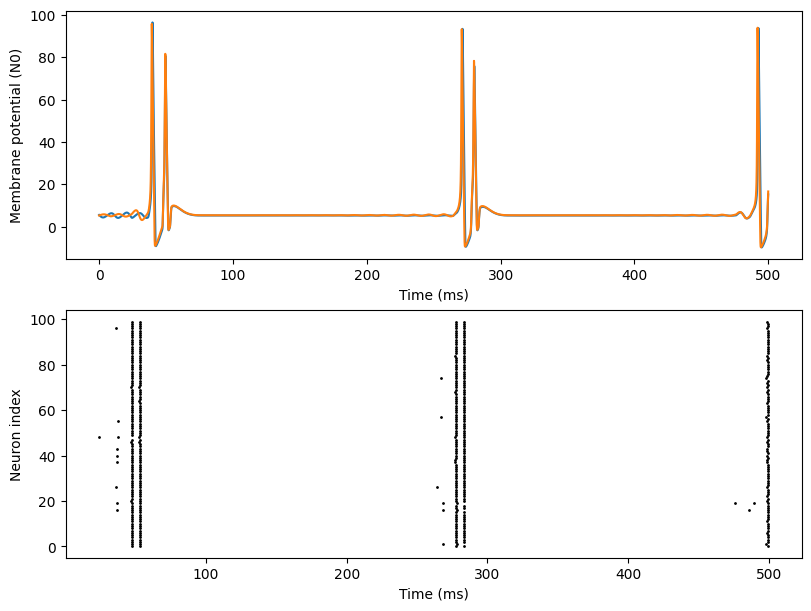

In [13]:
syn = AMPAAll2All(pre=neu, post=neu, conn=bp.connect.All2All(include_self=False)) #include_self=False)) #,stop_spike_gradient=False)
# syn = AMPAAll2All(pre=neu, post=neu, conn= bp.connect.FixedProb(prob=0.2, include_self=True))
# syn = bp.dyn.GABAa.desc(pre=neu, post=neu, prob=1) #conn=bp.connect.All2All(include_self=False)) #,stop_spike_gradient=False)

shape = (100,100)
syn.g_max = bp.init.Normal(mean=0.1, scale=0.02)(shape) #.value

# net = bp.Network(pre=neu, post=neu ,syn=syn)
net = bp.Network(neu=neu, syn=syn)
runner = bp.DSRunner(net, monitors=['neu.spike', 'neu.V'], inputs=['neu.input',bm.random.uniform(9,10,100)]) #
runner.run(duration=1500.) #,inputs=inputs )

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts[15000:], runner.mon['neu.V'][15000:,0], ylabel='Membrane potential (N0)')
bp.visualize.line_plot(runner.mon.ts[15000:], runner.mon['neu.V'][15000:,10])

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts[15000:], runner.mon['neu.spike'][15000:], show=True)
plt.show()


In [34]:
syn1.proj.comm.weight.shape

(100, 100)

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPreMg2 is deprecated. Use brainpy.dyn.FullProjAlignPreDSMg instead.
  _deprecate(message)


  0%|          | 0/12500 [00:00<?, ?it/s]

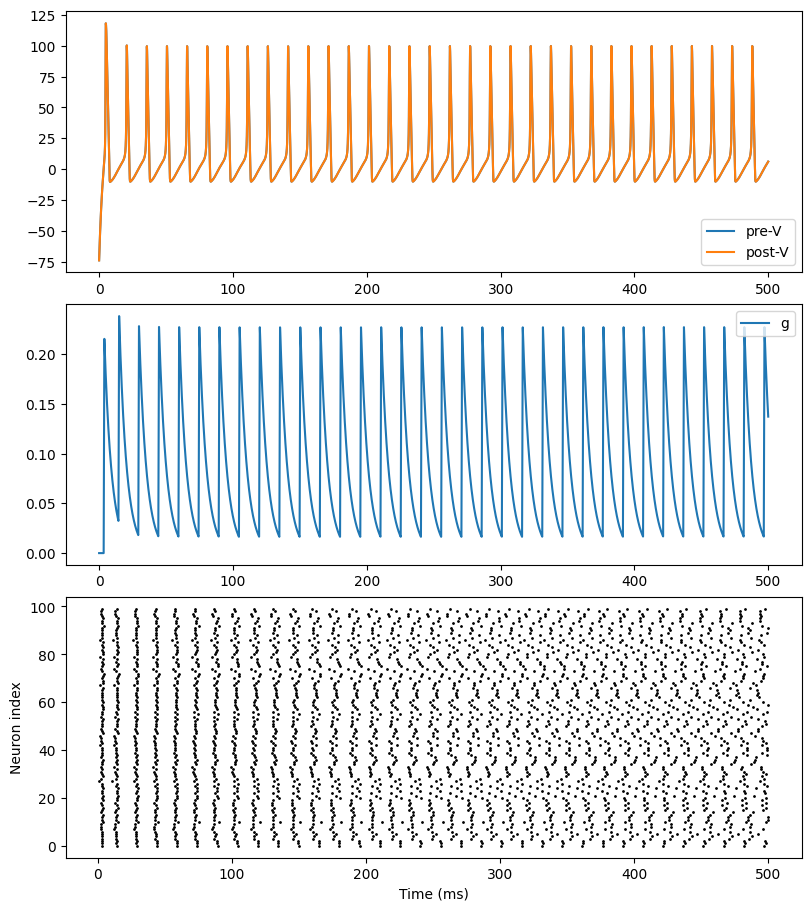

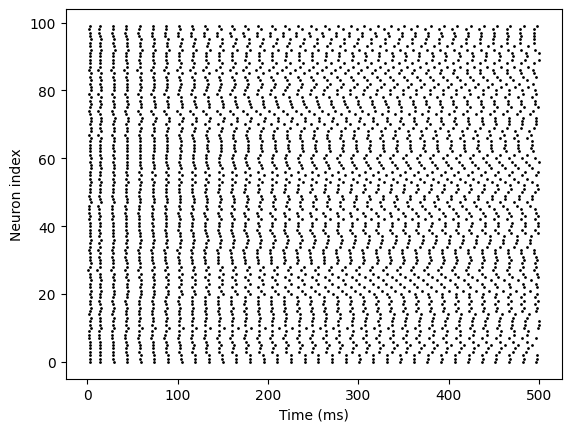

In [30]:
class AMPA(bp.Projection):
    def __init__(self, pre, post, delay, g_max, E=0.):
        super().__init__()
        self.proj = bp.dyn.ProjAlignPreMg2(
          pre=pre, 
          delay=delay, 
          syn=bp.dyn.AMPA.desc(pre.num, alpha=0.98, beta=0.18, T=0.5, T_dur=0.5),
          comm=bp.dnn.AllToAll(pre.num, post.num, g_max),
          out=bp.dyn.COBA(E=E),
          post=pre, 
        )
neu1 = neu
neu2 = neu
shape = (100,100)
syn1 = AMPA(neu1, neu2, None,bp.init.Normal(mean=0.1, scale=0.02)(shape)/99 ,E=20)

net = bp.DynSysGroup(pre=neu1, syn=syn1, post=neu2)
runner = bp.DSRunner(net,
                     inputs=(neu1.input, bm.random.uniform(9,10,100)),
                     monitors={'pre.V': neu1.V, 'post.V': neu2.V, 'syn.g': syn1.proj.refs['syn'].g, 'pre.spike': neu1.spike})
runner.run(500.)

import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(3, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(runner.mon.ts, runner.mon['pre.V'][:,0], label='pre-V')
plt.plot(runner.mon.ts, runner.mon['post.V'][:,0], label='post-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(runner.mon.ts, runner.mon['syn.g'][:,0], label='g')
plt.legend()

fig.add_subplot(gs[2, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['pre.spike'], show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['pre.spike'], show=True)

plt.show()





In [15]:
class SimpleNet(bp.DynSysGroup):
    def __init__(self, E=-70.):
        super().__init__()
        self.neu =  neu #bp.neurons.HH(100) #A(100)
        # self.neu.V[:] = -70. + bm.random.normal(size=100) * 20
        self.syn = bp.synapses.AMPA(pre=self.neu, post=self.neu, conn=bp.connect.All2All(include_self=False),stop_spike_gradient=False)#GABAa(self.pre,self.post, delay=0, prob=1., g_max=0.1/100, E=-75.)
        #bp.dyn.AMPA.desc(100, alpha=0.98, beta=0.18, T=0.5, T_dur=0.5)
        shape = (100,100)
        self.syn.g_max= bp.init.Normal(mean=0.1, scale=0.02)(shape)/99 ##0.1/100

    def update(self):

        self.neu.update(bm.random.uniform(9,10,100))
        self.syn()

        #self.post.update()

        conductance =  self.syn.g #proj.refs['syn'].g
        current = self.neu.sum_current_inputs(self.neu.V)
        return conductance, current, self.neu.V,self.neu.spike.value

In [16]:
#conductance is becoming zero .. ☹️.. no its not zero .. its just too small

In [17]:
net = SimpleNet(E=20.)
runner = bp.DSRunner(net)
conductances, currents, potentials, spikes = runner.run(duration=4000)


fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts[85000:],conductances[85000:, :], label='Neuron 0')
# bp.visualize.line_plot(runner.mon.ts[85000:], potentials[85000:, 1],label='Neuron 0')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts[85000:], spikes[85000:], show=True)
bp.visualize.raster_plot(runner.mon.ts[0:15000], spikes[0:15000], show=True)
plt.show()

/Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/dynold/synapses/base.py:338: UserWarning: Updating "<your_synapse>.g_max" is deprecated. Updating "<your_synapse>.comm.weight" instead.
  warnings.warn('Updating "<your_synapse>.g_max" is deprecated. '


  0%|          | 0/100000 [00:00<?, ?it/s]

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[100] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was fun2scan at /Users/shubhangi_goyal/opt/miniconda3/lib/python3.9/site-packages/brainpy/_src/math/object_transform/controls.py:735 traced for scan.
------------------------------
The leaked intermediate value was created on line /var/folders/77/nrqlf59s63vdthtspt0vrg4h0000gn/T/ipykernel_16906/1667282261.py:21 (<module>). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/var/folders/77/nrqlf59s63vdthtspt0vrg4h0000gn/T/ipykernel_16906/1667282261.py:21 (<module>)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError